# Developing and visualising metrics

## Imports

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import json
import random
from scipy.stats import spearmanr
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import asyncio
import nest_asyncio
nest_asyncio.apply()

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import pubmetric.network as nw
import pubmetric.pckg_dev as dev
import pubmetric.metrics as met

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom colour palette with #f2634c as the primary colour
palette = [
    '#f2634c', # Primary red colour
    '#3a3a3a', # Dark grey
    '#b0b0b0', # Light grey
    '#e0e0e0', # Very light grey
    '#0091d5', # Complementary blue
    '#7a7a7a', # Medium grey
    '#6dbd45', # Complementary green
    '#f5c6cb', # Soft pink
    '#c9d6e3', # Pale blue
    '#a9b7c6', # Soft steel blue
    '#f4f4f4'  # Near white
]

red_palette = sns.color_palette("Reds", n_colors=15).as_hex()[::-1]

# Set the Seaborn theme with a sleek and professional style
sns.set_theme(style="whitegrid", palette=palette, rc={
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'grid.alpha': 0.3, # Less intrusive gridlines
    'grid.linestyle': '--',
    'legend.frameon': True,
    'legend.loc': 'upper left', # Legend outside the plot
    'legend.borderpad': 1,
    'legend.labelspacing': 1,
    'legend.handlelength': 2.5,
    'legend.handletextpad': 1,
    'figure.figsize': (10, 6) # Wider figure size
})

In [3]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(nw.create_citation_network(inpath=path_to_data, load_graph=True))

2024-08-09 19:51:32 - Graph loaded from ../out_20240801231111


# Expert Rated Dataset 

## Load dataset

In [5]:
# LOAD training data  
with open('../data/train_rated.json', 'r') as json_file:
    train_set = json.load(json_file)

print(len(train_set))
print(train_set[0]) # one workflow

pmid_workflows = [item['pmid_workflow'] for item in train_set]
expert_ratings = [workflow['ratingAvg'] for workflow in train_set]

250
{'ratingAvg': 0.5, 'expert1': 0.0, 'expert2': 1.0, 'workflow': [['msConvert', 'Comet'], ['Comet', 'ProteinProphet'], ['ProteinProphet', 'PeptideProphet']], 'pmid_workflow': [['23051804', '23148064'], ['23148064', '14632076'], ['14632076', '12403597']], 'usecase': 2, 'scenario': 'Original ', 'id': 177, 'rating_bin': '0-1'}


## Running metrics

In [6]:
workflow_average_score = []
degree_workflow_average_score = []
log_worfklow_average_score = []
sqrt_worfklow_average_score = []
workflow_product_score = []
log_workflow_product_score = []
connectivity_score = []
workflow_weighted_connectivity_score = []
age_workflow_average_score = []
age_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
citation_scores = []
random_scores = []
path_scores = []

random.seed(42)


for workflow in pmid_workflows:
    workflow_average_score.append(met.workflow_average_sum(graph=loaded_graph, workflow=workflow))
    degree_workflow_average_score.append(met.degree_workflow_average_sum(graph=loaded_graph, workflow=workflow))
    log_worfklow_average_score.append(met.transformed_workflow_average_sum(graph=loaded_graph, workflow=workflow))
    sqrt_worfklow_average_score.append(met.transformed_workflow_average_sum(graph=loaded_graph, workflow=workflow, transform='sqrt'))
    workflow_product_score.append(met.workflow_edge_product(graph=loaded_graph, workflow=workflow))
    log_workflow_product_score.append(met.log_workflow_edge_product(graph=loaded_graph, workflow=workflow))
    connectivity_score.append(met.connectivity(graph=loaded_graph, workflow=workflow))
    workflow_weighted_connectivity_score.append(met.workflow_weighted_connectivity(graph=loaded_graph, workflow=workflow, factor=4.0))
    age_workflow_average_score.append(met.age_workflow_average_sum(graph=loaded_graph, workflow=workflow))
    age_connectivity_score.append(met.age_connectivity(graph=loaded_graph, workflow=workflow))
    min_connectivity_score.append(met.min_connectivity(loaded_graph, workflow))
    citations_connectivity_score.append(met.citation_connectivity(loaded_graph, workflow))
    citation_scores.append(met.median_citations(loaded_graph, workflow))
    random_scores.append(random.randrange(0,6))
    path_scores.append(met.shortest_path(graph=loaded_graph, workflow=workflow))


### "Evaluating" metrics

In [11]:
# Metrics and their names
metrics = [
    workflow_average_score, connectivity_score, path_scores, citation_scores, degree_workflow_average_score, log_worfklow_average_score, sqrt_worfklow_average_score, workflow_product_score, log_workflow_product_score, 
    workflow_weighted_connectivity_score, age_workflow_average_score, age_connectivity_score, min_connectivity_score, citations_connectivity_score, min_connectivity_score, citations_connectivity_score,
     random_scores
]


metric_names = [
    'Workflow Average Score', 'Connectivity Score', 'Shortest-path Score', 'Citation Scores', 'Degree Workflow Average Score', 'Log Workflow Average Score', 'Square-root Workflow Average Score',
    'Workflow Product Score', 'Log Workflow Product Score', 
    'Workflow Weighted Connectivity Score', 'Age Workflow Average Score', 'Age Connectivity Score',
    'Min Connectivity Score', 'Citations Connectivity Score', 'Min Scores', 
    'Citation Normalised Scores',  'Random Scores'
]


In [12]:
half = len(expert_ratings) // 2

correlations = []
for metric in metrics:
    full_correlation, full_p_value = spearmanr(expert_ratings, metric)
    
    first_half_correlation, first_half_p_value = spearmanr(expert_ratings[:half], metric[:half])
    second_half_correlation, second_half_p_value = spearmanr(expert_ratings[half:], metric[half:])
    
    # Variation score (difference in correlations between the two halves)
    variation_score = first_half_correlation - second_half_correlation
    
    correlations.append({
        'full': (round(full_correlation, 4), full_p_value),
        'first_half': (round(first_half_correlation, 4), first_half_p_value),
        'second_half': (round(second_half_correlation, 4), second_half_p_value),
        'variation_score': round(variation_score, 4)
    })

for idx, corr in enumerate(correlations):
    print(f"Metric {idx+1}:")
    print(f"  Full data: Correlation = {corr['full'][0]}, p-value = {corr['full'][1]:.1E}")
    print(f"  First half: Correlation = {corr['first_half'][0]}, p-value = {corr['first_half'][1]:.1E}")
    print(f"  Second half: Correlation = {corr['second_half'][0]}, p-value = {corr['second_half'][1]:.1E}")
    print(f"  Variation score: {corr['variation_score']}")


Metric 1:
  Full data: Correlation = 0.3219, p-value = 2.0E-07
  First half: Correlation = 0.3242, p-value = 2.3E-04
  Second half: Correlation = 0.3219, p-value = 2.5E-04
  Variation score: 0.0023
Metric 2:
  Full data: Correlation = 0.2433, p-value = 1.0E-04
  First half: Correlation = 0.261, p-value = 3.3E-03
  Second half: Correlation = 0.23, p-value = 9.9E-03
  Variation score: 0.0311
Metric 3:
  Full data: Correlation = 0.1769, p-value = 5.0E-03
  First half: Correlation = 0.238, p-value = 7.5E-03
  Second half: Correlation = 0.1207, p-value = 1.8E-01
  Variation score: 0.1174
Metric 4:
  Full data: Correlation = 0.3154, p-value = 3.5E-07
  First half: Correlation = 0.3613, p-value = 3.5E-05
  Second half: Correlation = 0.2744, p-value = 2.0E-03
  Variation score: 0.0868
Metric 5:
  Full data: Correlation = 0.3125, p-value = 4.6E-07
  First half: Correlation = 0.3169, p-value = 3.2E-04
  Second half: Correlation = 0.3098, p-value = 4.4E-04
  Variation score: 0.0071
Metric 6:
  Fu

#### Scatter - metric scores against expert scores

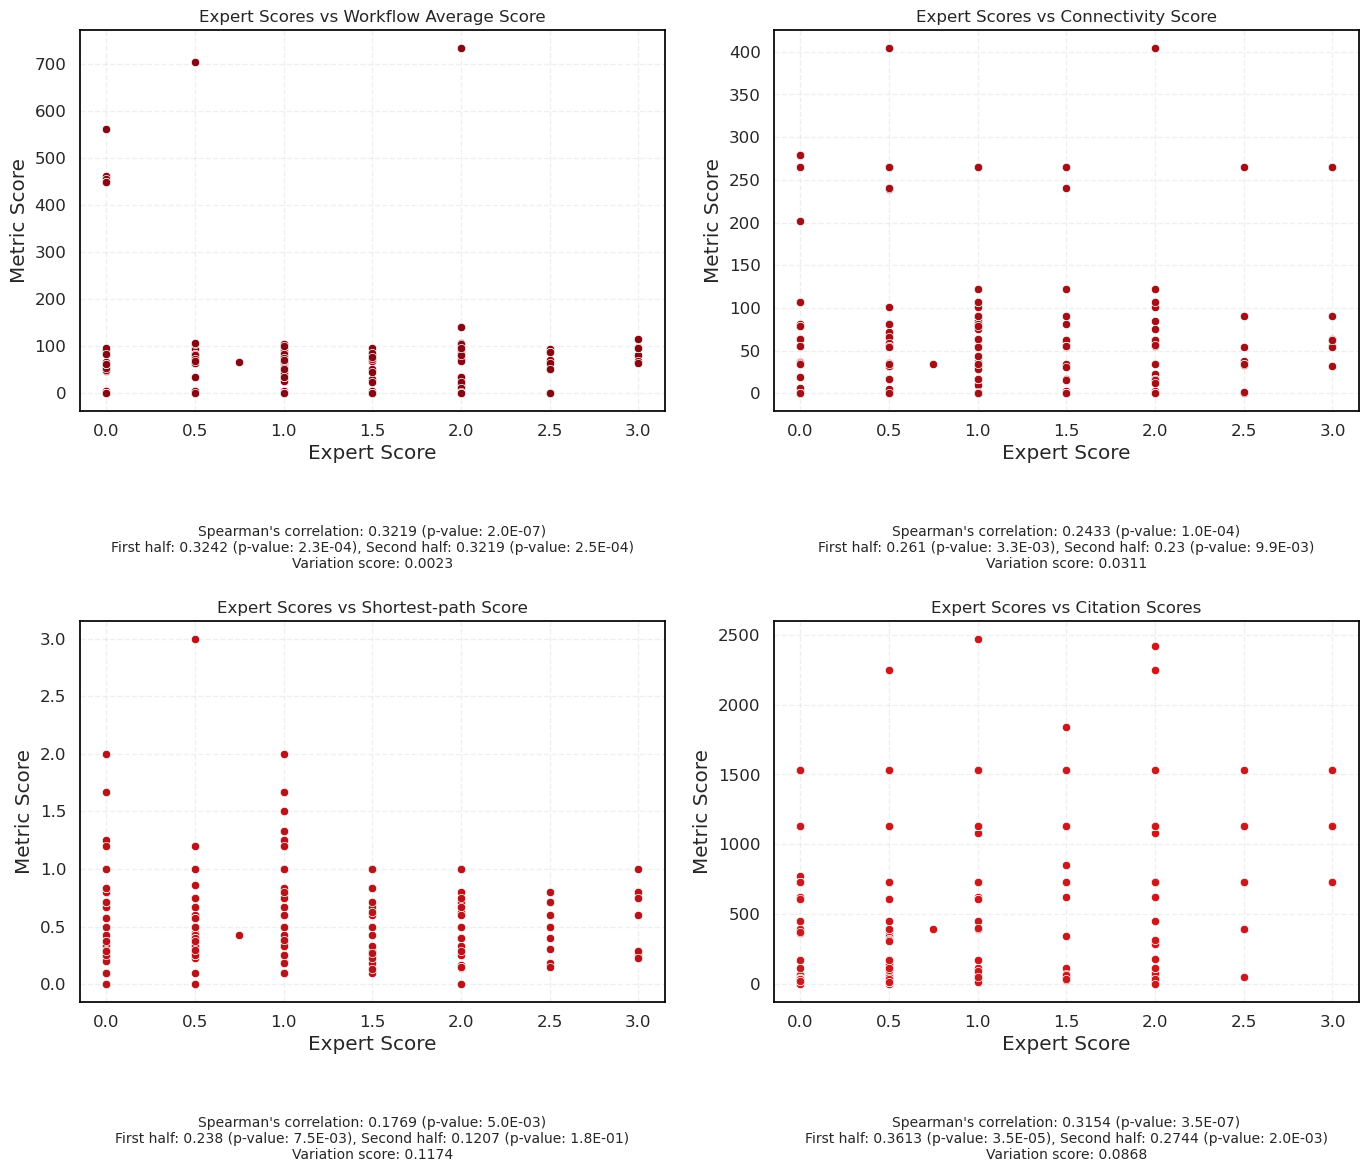

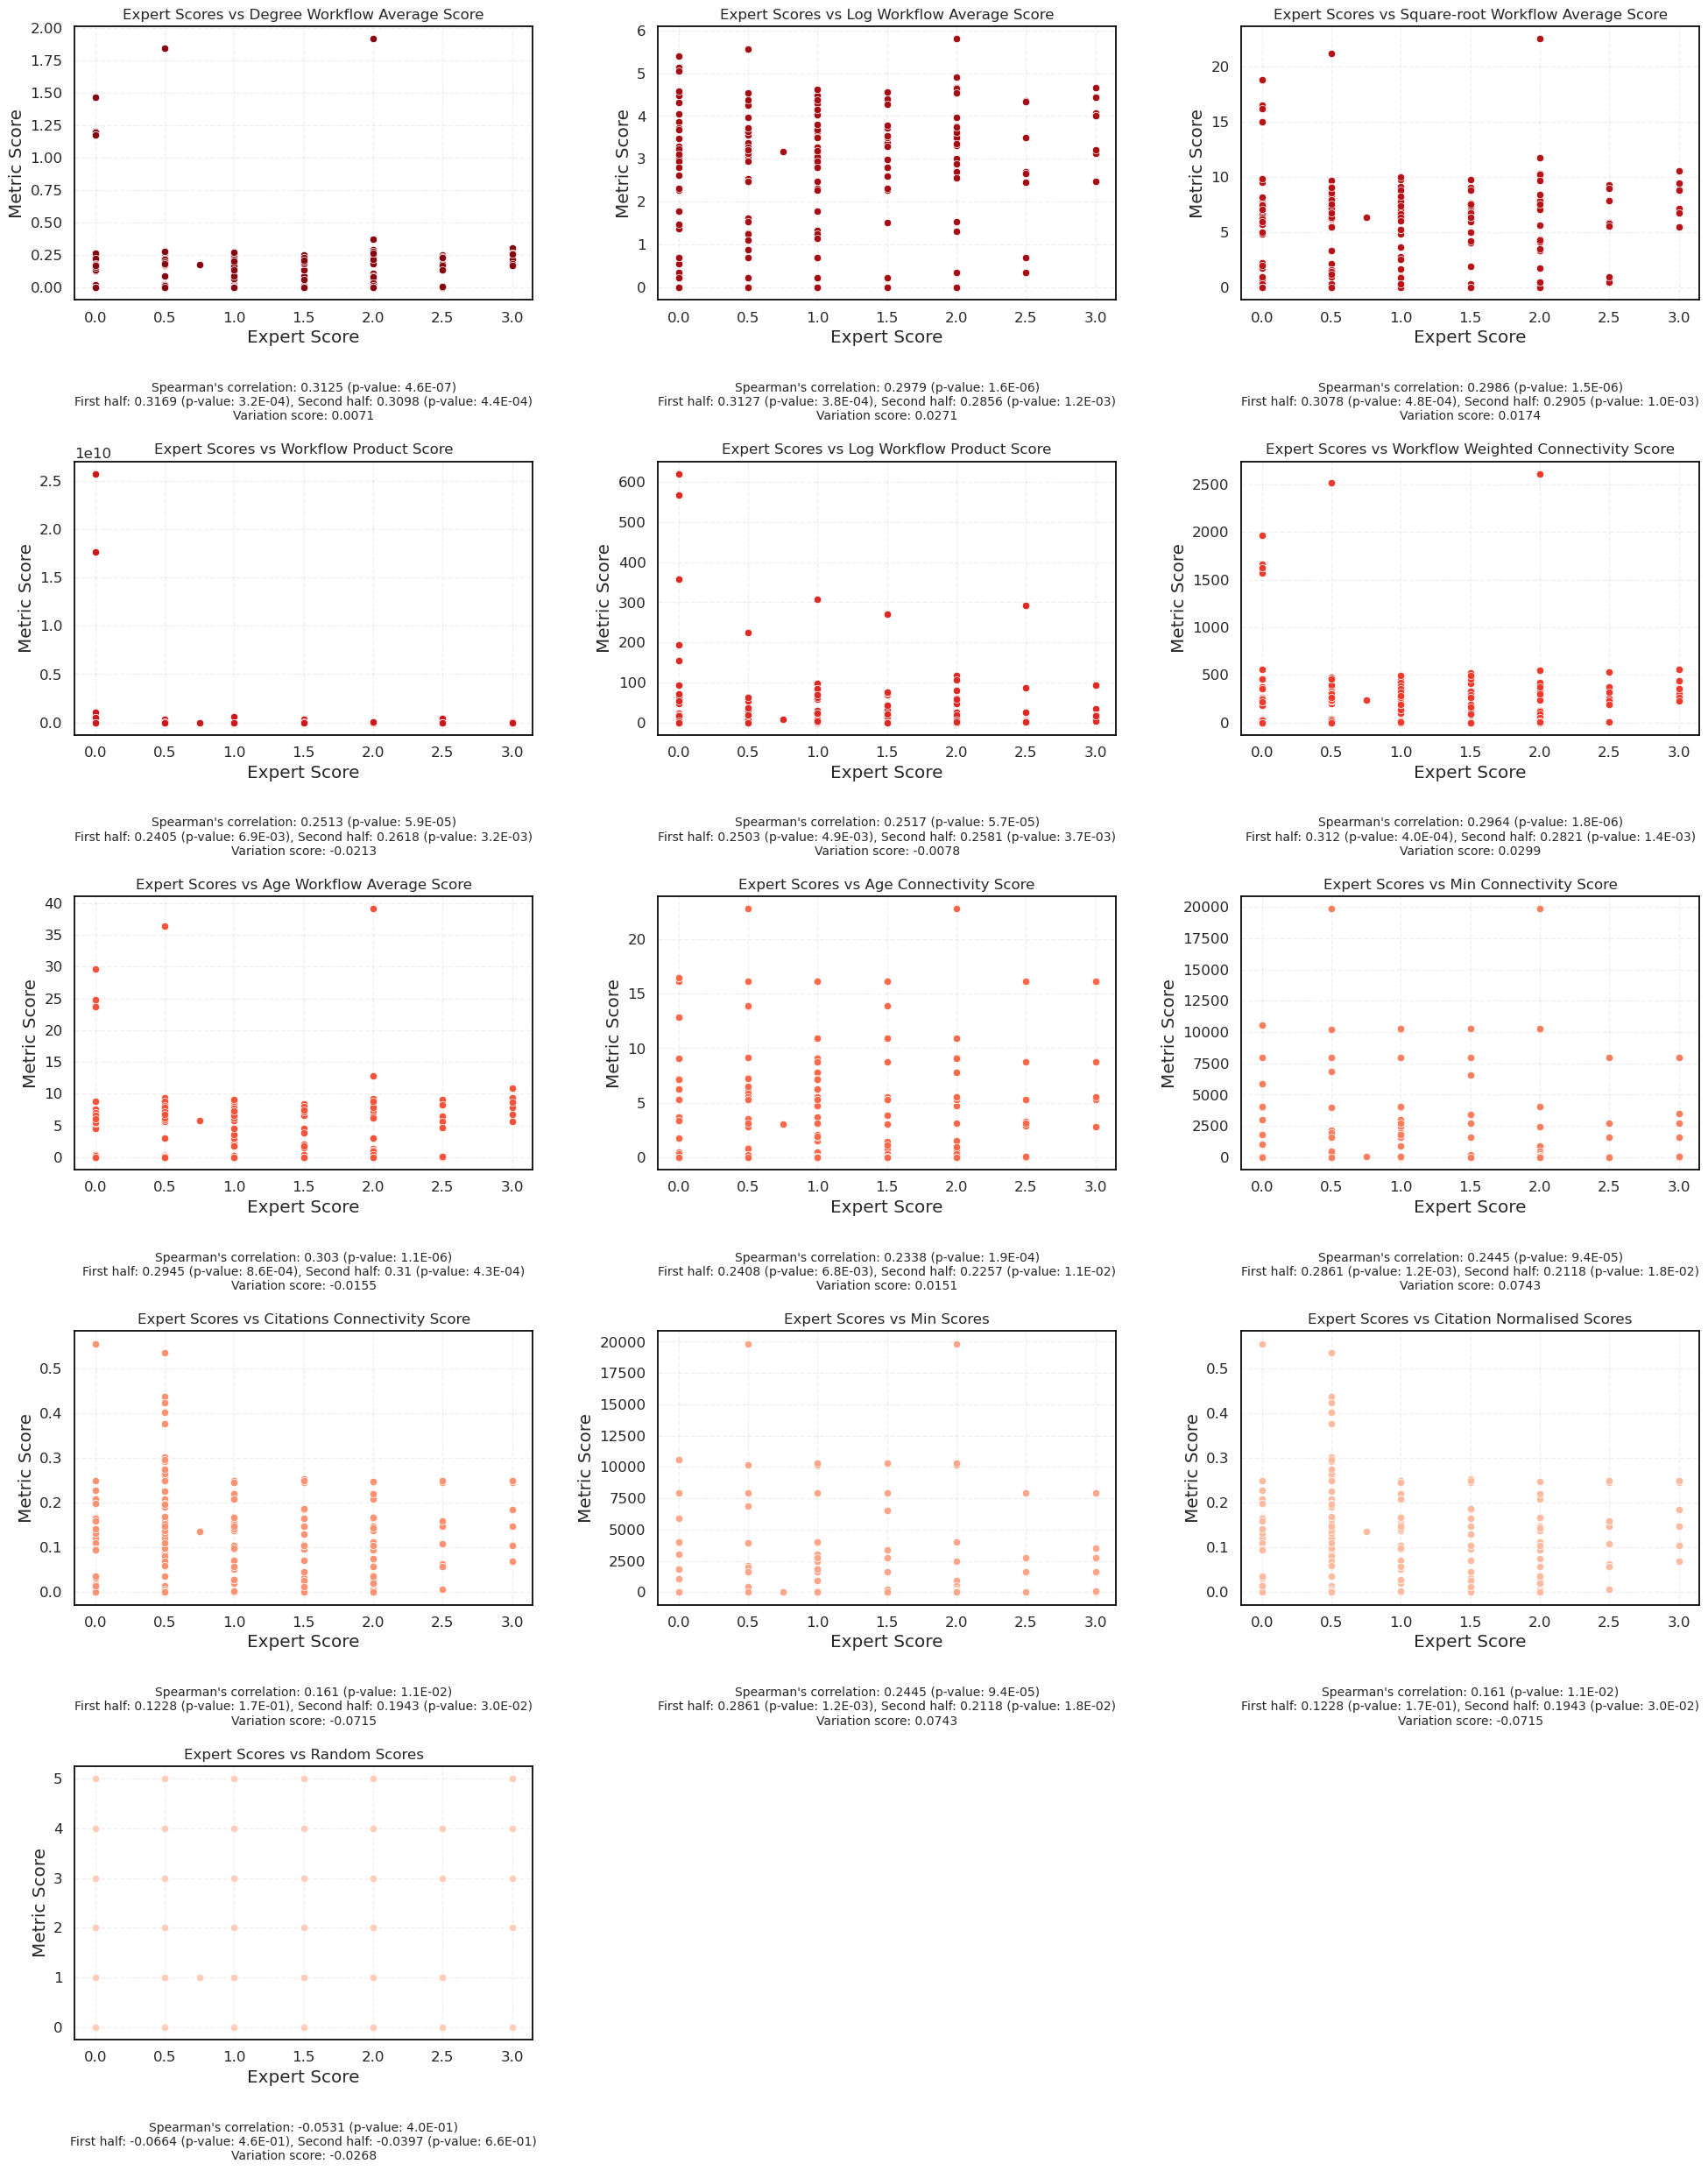

In [15]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes1 = axes1.flatten()

for idx, (metric, name, colour, corr) in enumerate(zip(metrics[:4], metric_names[:4], red_palette[:4], correlations[:4])):
    sns.scatterplot(x=expert_ratings, y=metric, color=colour, ax=axes1[idx])
    axes1[idx].set_title(f'Expert Scores vs {name}')
    axes1[idx].set_xlabel('Expert Score')
    axes1[idx].set_ylabel('Metric Score')
    description = (f'Spearman\'s correlation: {corr["full"][0]} (p-value: {corr["full"][1]:.1E})\n'
                   f'First half: {corr["first_half"][0]} (p-value: {corr["first_half"][1]:.1E}), '
                   f'Second half: {corr["second_half"][0]} (p-value: {corr["second_half"][1]:.1E})\n'
                   f'Variation score: {corr["variation_score"]}')
    axes1[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes1[idx].transAxes, fontsize=10)

for ax in axes1[len(metrics[:4]):]:
    fig1.delaxes(ax)

plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes2 = axes2.flatten()

for idx, (metric, name, colour, corr) in enumerate(zip(metrics[4:], metric_names[4:], red_palette, correlations[4:])):
    sns.scatterplot(x=expert_ratings, y=metric, color=colour, ax=axes2[idx])
    axes2[idx].set_title(f'Expert Scores vs {name}')
    axes2[idx].set_xlabel('Expert Score')
    axes2[idx].set_ylabel('Metric Score')
    description = (f'Spearman\'s correlation: {corr["full"][0]} (p-value: {corr["full"][1]:.1E})\n'
                   f'First half: {corr["first_half"][0]} (p-value: {corr["first_half"][1]:.1E}), '
                   f'Second half: {corr["second_half"][0]} (p-value: {corr["second_half"][1]:.1E})\n'
                   f'Variation score: {corr["variation_score"]}')
    axes2[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes2[idx].transAxes, fontsize=10)

for ax in axes2[len(metrics[4:]):]:
    fig2.delaxes(ax)

plt.tight_layout()
plt.show()


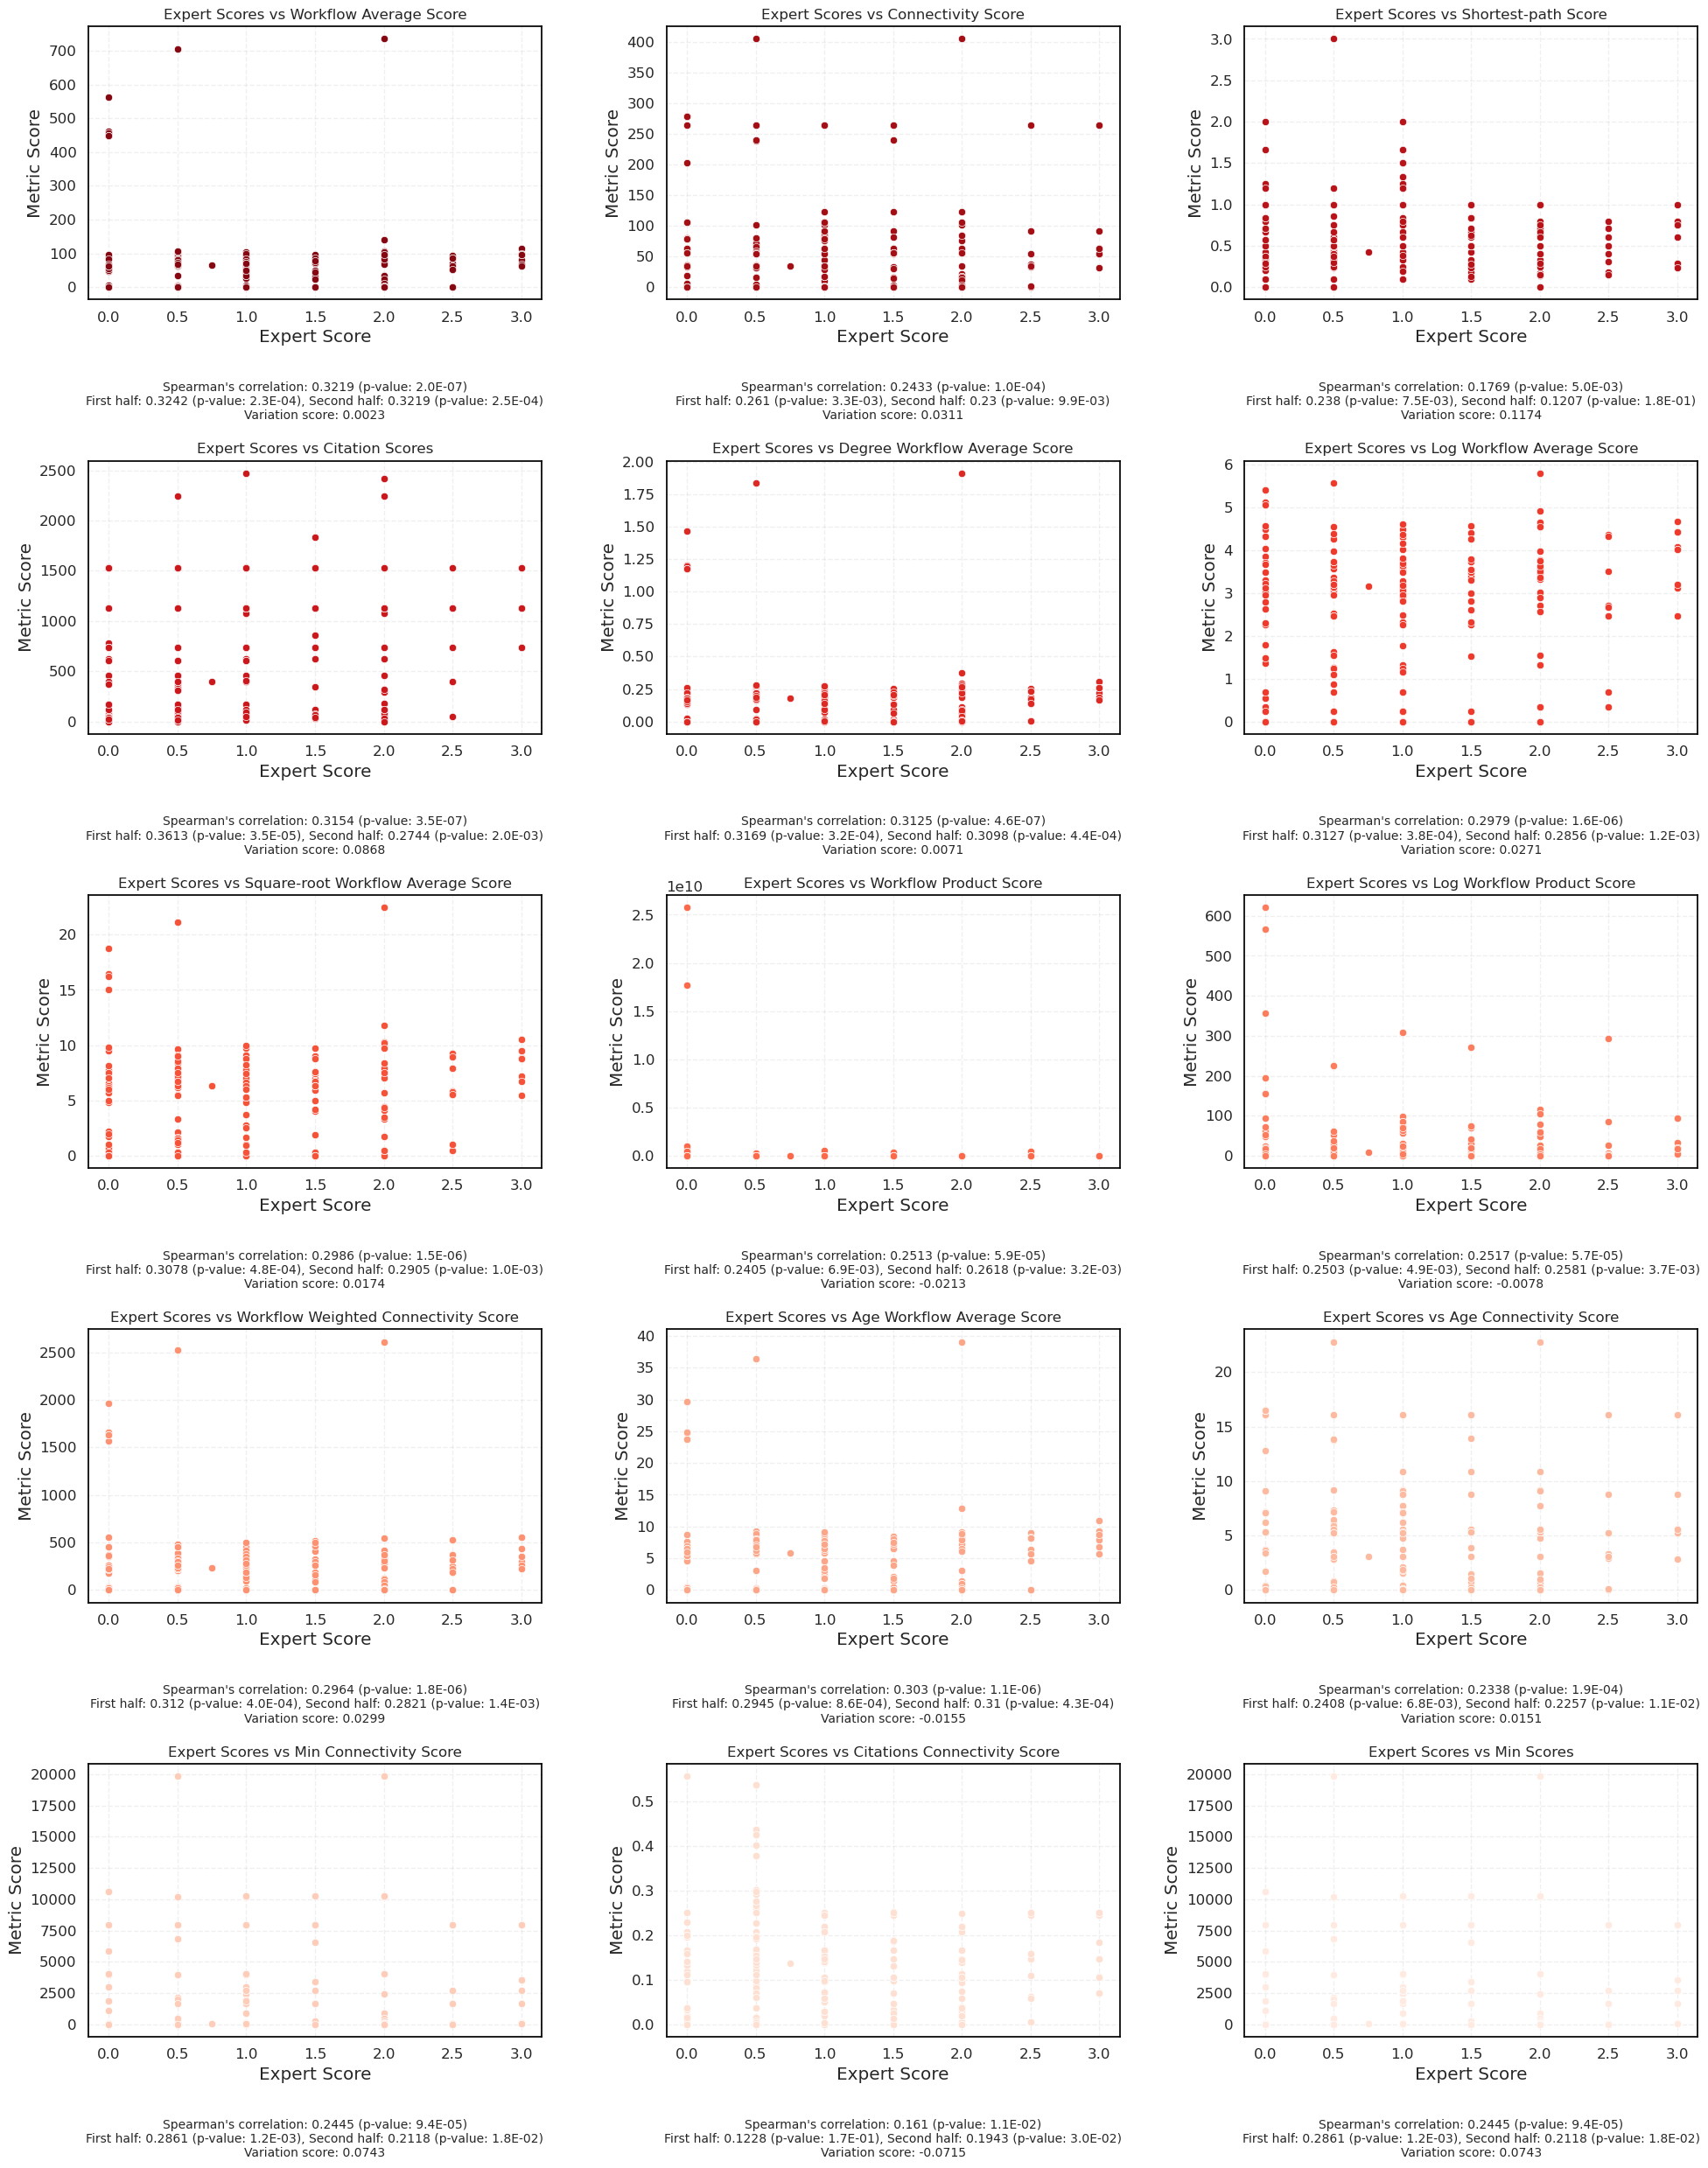

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()

# increase in 

for idx, (metric, name, colour, corr) in enumerate(zip(metrics, metric_names, red_palette, correlations)):
    sns.scatterplot(x=expert_ratings, y=metric, color=colour, ax=axes[idx])
    axes[idx].set_title(f'Expert Scores vs {name}')
    axes[idx].set_xlabel('Expert Score')
    axes[idx].set_ylabel('Metric Score')
    description = (f'Spearman\'s correlation: {corr["full"][0]} (p-value: {corr["full"][1]:.1E})\n'
                   f'First half: {corr["first_half"][0]} (p-value: {corr["first_half"][1]:.1E}), '
                   f'Second half: {corr["second_half"][0]} (p-value: {corr["second_half"][1]:.1E})\n'
                   f'Variation score: {corr["variation_score"]}')
    axes[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes[idx].transAxes, fontsize=10)

for ax in axes[len(metrics):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

##### Testing on a fake network to illustrate how they work 

In [ ]:
### Testing metrics on example tree
# The network

# Define the nodes 
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CQ', 'TE'), ('CQ', 'TF'), ('CO', 'TE'),
    ('CO', 'TF') 
]

nodes_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF', 'CJ', 'CK', 'CL', 'CO', 'CQ' ]
tools_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF']


testgraph = igraph.Graph.TupleList(edges, directed=True)
incuded_tools = [tool for tool in testgraph.vs['pmid'] if tool in tools] #could do interrsection    
test_coG = nw.create_cocitation_graph(testgraph,incuded_tools)

layout = test_coG.layout("fr")

# Create plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the graph
igraph.plot(
    test_coG,
    target=ax,
    layout=layout,
    vertex_size=0.3,
    vertex_color='skyblue',
    vertex_frame_color='white',
    vertex_label=test_coG.vs['pmid'],
    vertex_label_size=10,
    edge_width=[0.5 + 2 * w for w in test_coG.es['weight']],
    edge_color='gray',
    edge_label=test_coG.es['weight'],
    edge_label_size=10
)

# Display plot
plt.show()

print( testgraph.vs['pmid'])
print( test_coG.vs['pmid'])

print( test_coG.es['weight'])

expected_edge_weights = {('TA', 'TB'): 3, ('TA', 'TC'): 2, ('TA', 'TD'): 1,
('TB', 'TC'): 3, ('TB', 'TD'): 1,
('TC', 'TD'): 1, 
('TE', 'TF'): 2, 
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection

def test_get_graph_edge_weight():
    for edge, expected_weight in expected_edge_weights.items():
        print(edge,expected_weight)
        weight = get_graph_edge_weight(test_coG, edge)
        print( weight == expected_weight)
test_get_graph_edge_weight()

print(connectivity(test_coG, [('TA', 'TB'), ('TA', 'TC'), ('TA', 'TD')]))

# Random dataset

In [5]:
with open('../data/random_dataset.json') as f:
    random_dataset = json.load(f)

## On workflow average, connectivity and median citations

In [6]:
workflow_average_score = []
connectivity_score = []
citation_scores = []
path_scores = []


for workflows in random_dataset:

    ape_workflow = workflows['APE_workflow']
    retained_degree_random_workflow = workflows['retained_degree_random_workflow']
    completely_random_workflow = workflows['completely_random_workflow']

    workflow_average_score.append((
        met.workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    connectivity_score.append((
        met.connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citation_scores.append((
        met.median_citations(graph=loaded_graph, workflow=ape_workflow),
        met.median_citations(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.median_citations(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    path_scores.append((
        met.shortest_path(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.shortest_path(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.shortest_path(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))


/home/alma/Documents/UU/Thesis/Git/Finalrepo/workflomics-QCmetric/src/pubmetric/metrics.py:117: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  path_length = graph.get_shortest_paths(u_index, to=v_index, weights=graph.es["inverted_weight"], output="epath")


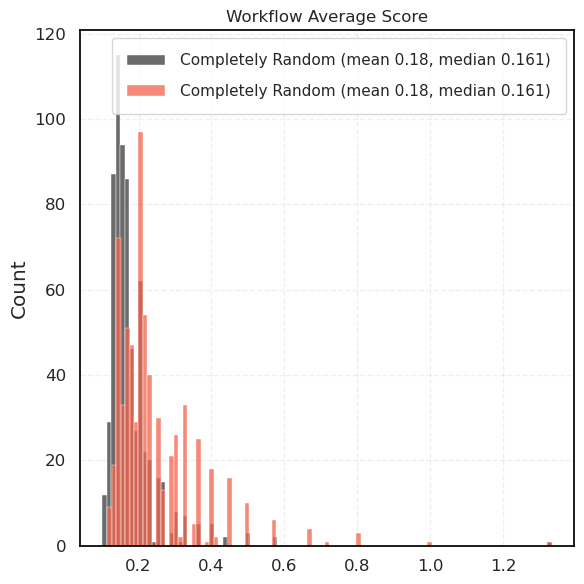

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

nr_bins = 100
# Unpack the metrics
ape_scores, retained_degree_scores, completely_random_scores = zip(*path_scores)
# Invert the completely random scores

# Plot the histogram
sns.histplot(completely_random_scores, bins=nr_bins, ax=ax, color=palette[1], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')
sns.histplot(ape_scores, bins=nr_bins, ax=ax, color=palette[0], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')

# Set title and legend
ax.set_title('Workflow Average Score')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


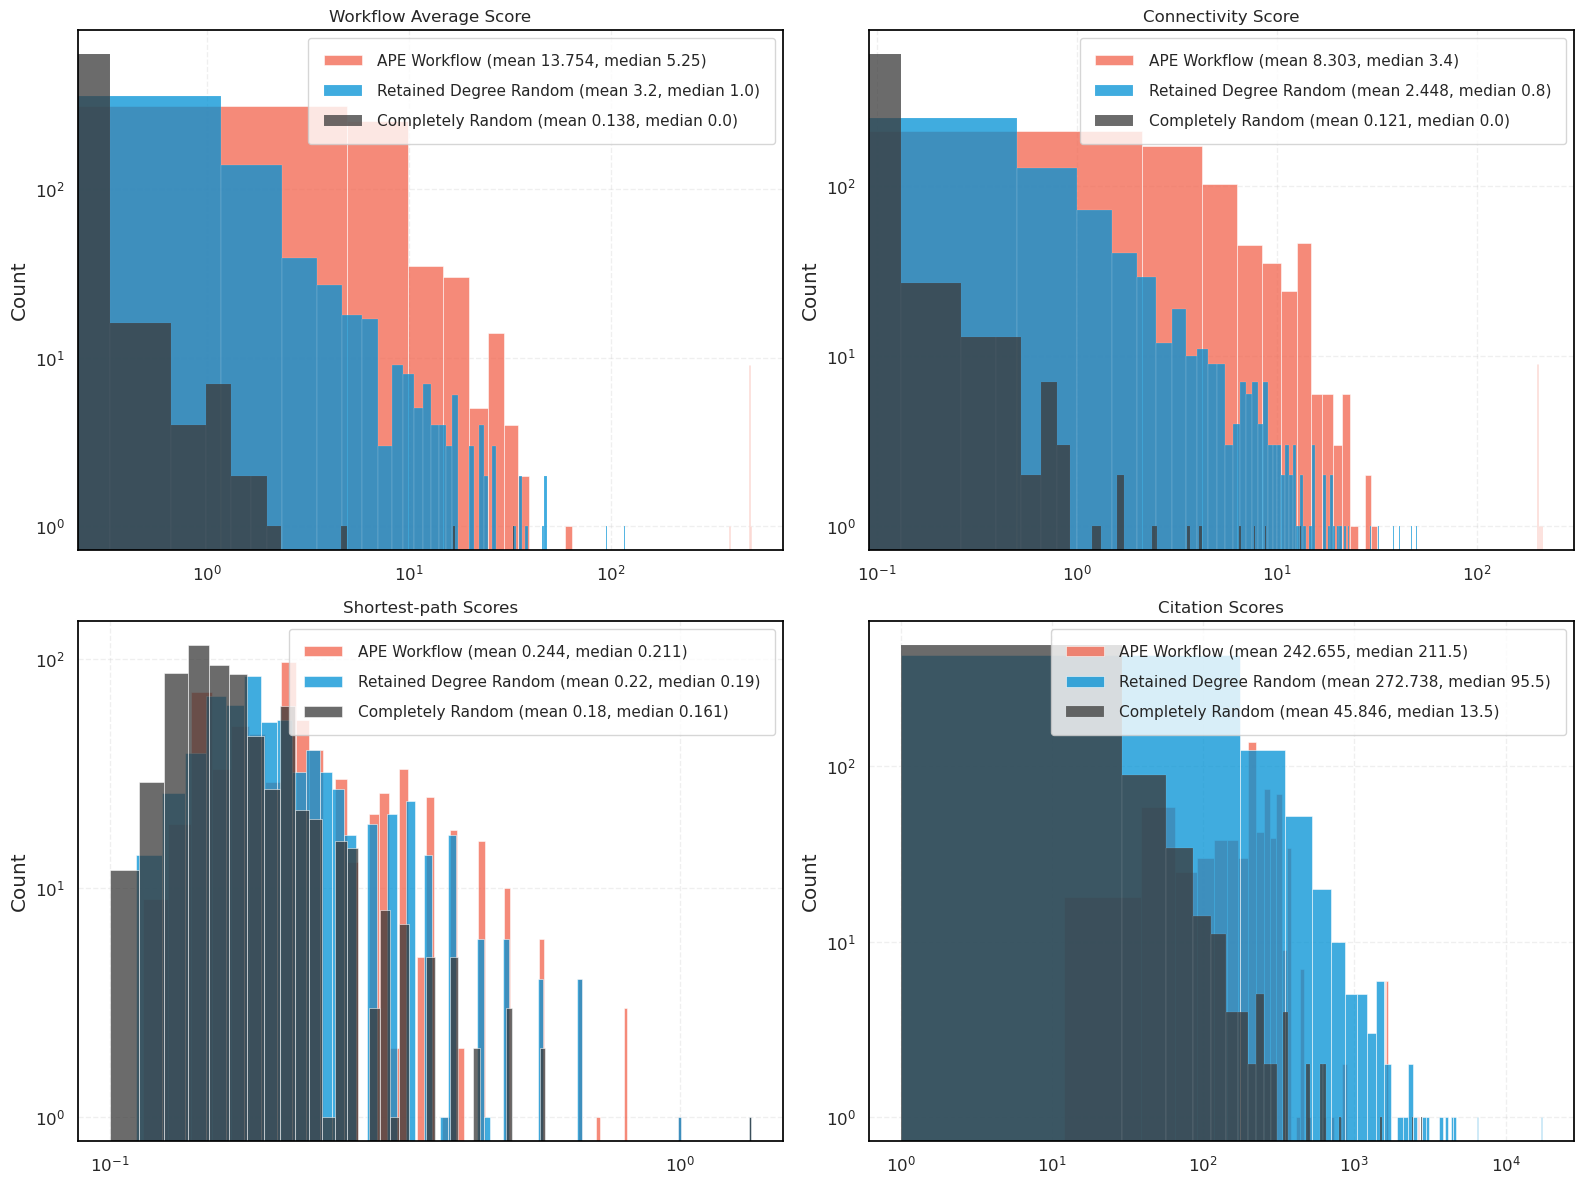

In [11]:

red_palette = sns.color_palette("Reds", n_colors=3).as_hex()[::-1]


metrics = [
    workflow_average_score, connectivity_score, path_scores, citation_scores
]

metric_names = [
    'Workflow Average Score', 'Connectivity Score', 'Shortest-path Scores', 'Citation Scores'
]

fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(16, 12))
axes = axes.flatten()



for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    
    nr_bins = 100
    sns.histplot(ape_scores, bins=nr_bins, ax=axes[idx], color=palette[0], label=f'APE Workflow (mean {round(np.mean(ape_scores), 3)}, median {round(np.median(ape_scores), 3)})')
    sns.histplot(retained_degree_scores, bins=nr_bins, ax=axes[idx], color=palette[4],  label=f'Retained Degree Random (mean {round(np.mean(retained_degree_scores), 3)}, median {round(np.median(retained_degree_scores), 3)})')
    sns.histplot(completely_random_scores, bins=nr_bins, ax=axes[idx], color=palette[1], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')



    axes[idx].legend(loc='upper right', bbox_to_anchor=(1, 1))
    axes[idx].set_yscale('log')
    axes[idx].set_xscale('log')
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()

## On all

In [29]:
workflow_average_score = []
degree_workflow_average_score = []
log_worfklow_average_score = []
workflow_product_score = []
log_workflow_product_score = []
connectivity_score = []
workflow_weighted_connectivity_score = []
age_workflow_average_score = []
age_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
citation_scores = []

for workflows in random_dataset:

    ape_workflow = workflows['APE_workflow']
    retained_degree_random_workflow = workflows['retained_degree_random_workflow']
    completely_random_workflow = workflows['completely_random_workflow']

    workflow_average_score.append((
        met.workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    degree_workflow_average_score.append((
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    log_worfklow_average_score.append((
        met.log_workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    workflow_product_score.append((
        met.workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    log_workflow_product_score.append((
        met.log_workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    age_workflow_average_score.append((
        met.age_workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.age_workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.age_workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    connectivity_score.append((
        met.connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    workflow_weighted_connectivity_score.append((
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    age_connectivity_score.append((
        met.age_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.age_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.age_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    min_connectivity_score.append((
        met.min_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.min_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.min_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citations_connectivity_score.append((
        met.citation_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.citation_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.citation_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citation_scores.append((
        met.median_citations(loaded_graph, ape_workflow),
        met.median_citations(loaded_graph, retained_degree_random_workflow),
        met.median_citations(loaded_graph, completely_random_workflow)
    ))


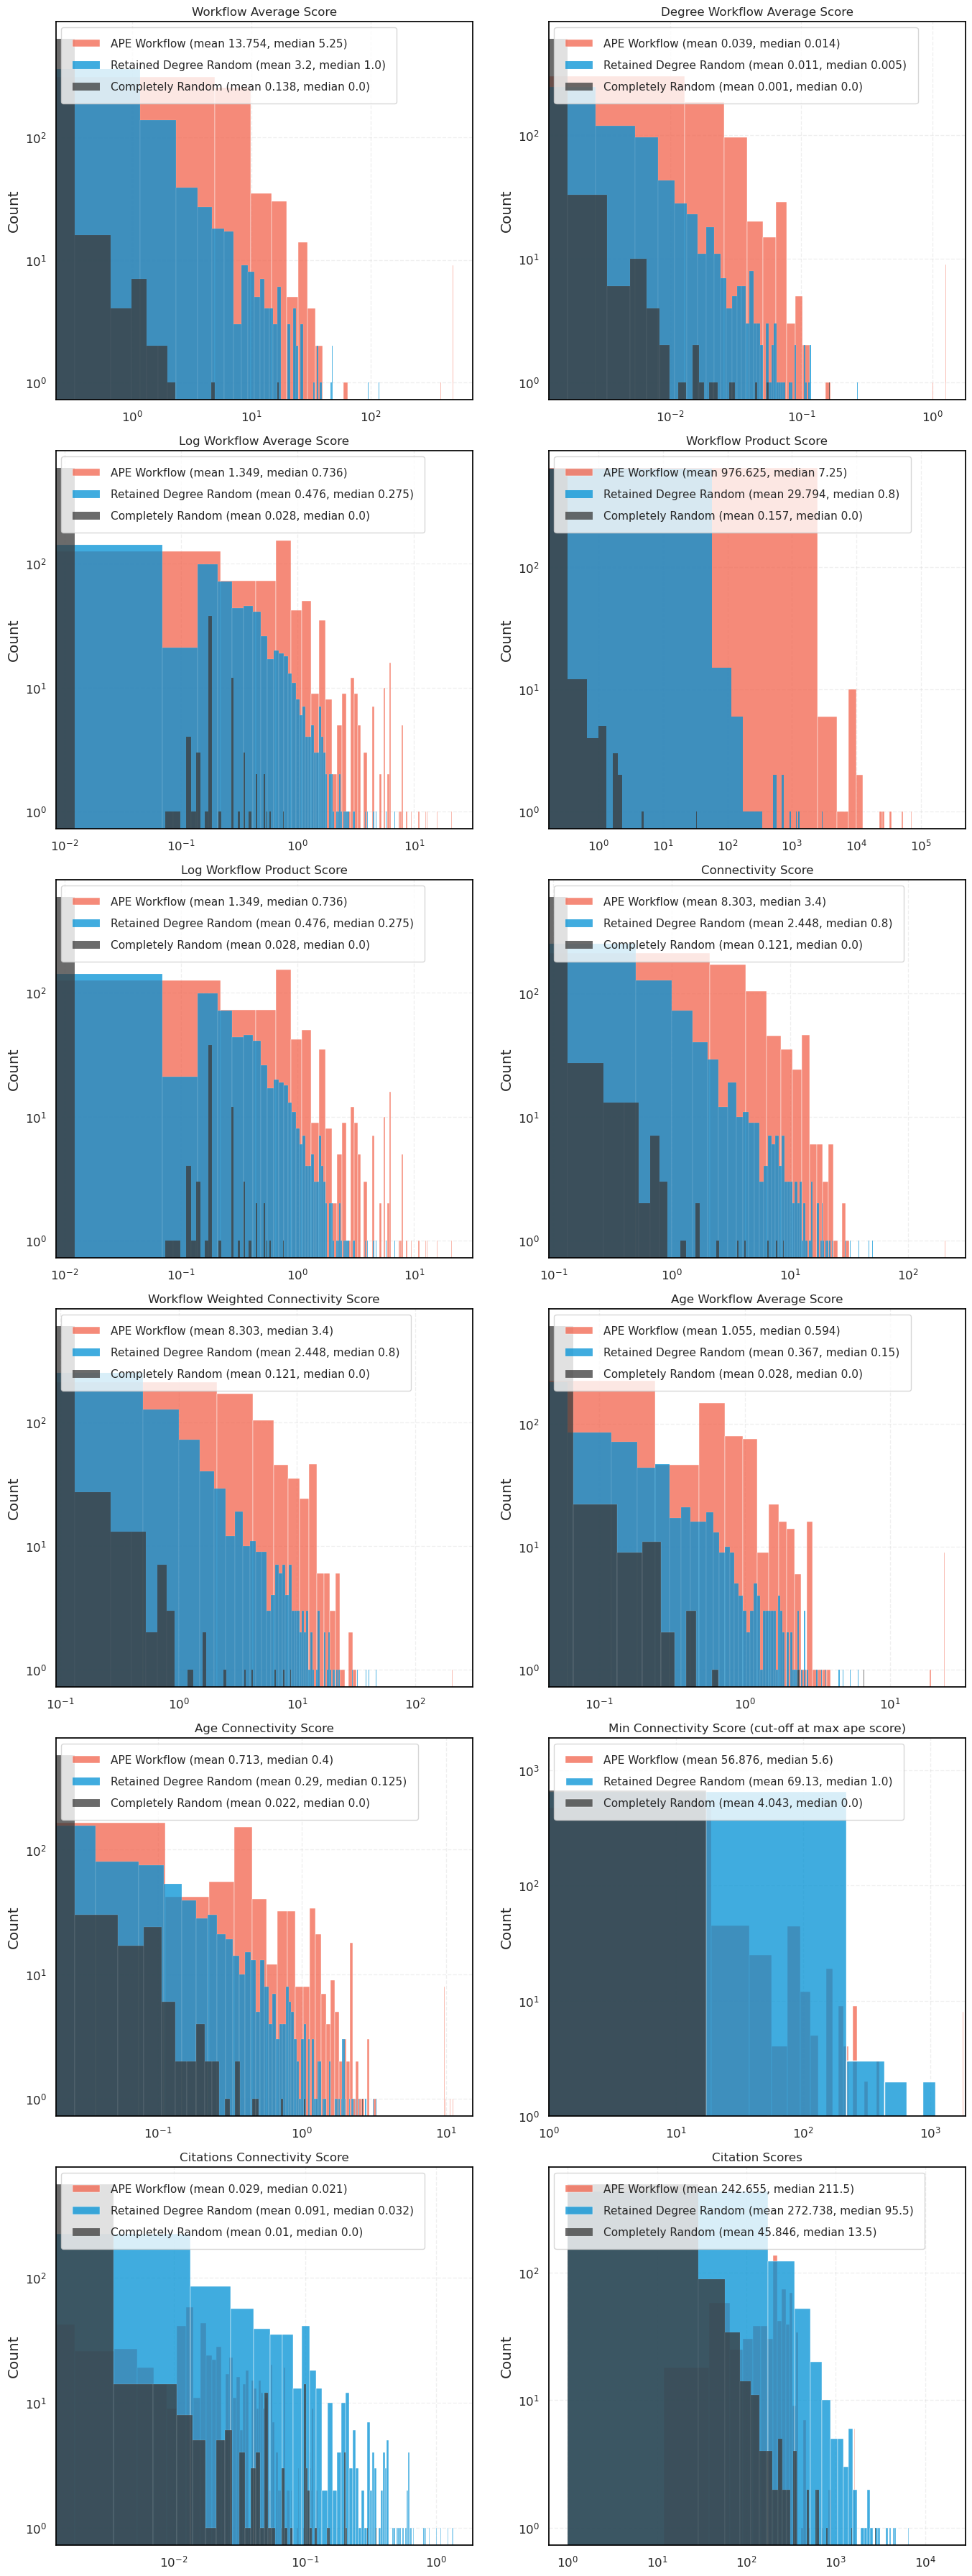

In [30]:

red_palette = sns.color_palette("Reds", n_colors=3).as_hex()[::-1]


metrics = [
    workflow_average_score, degree_workflow_average_score, log_worfklow_average_score, 
    workflow_product_score, log_workflow_product_score, connectivity_score, 
    workflow_weighted_connectivity_score, age_workflow_average_score, age_connectivity_score, 
    min_connectivity_score, citations_connectivity_score, citation_scores
]

metric_names = [
    'Workflow Average Score', 'Degree Workflow Average Score', 'Log Workflow Average Score',
    'Workflow Product Score', 'Log Workflow Product Score', 'Connectivity Score', 
    'Workflow Weighted Connectivity Score', 'Age Workflow Average Score', 'Age Connectivity Score',
    'Min Connectivity Score', 'Citations Connectivity Score', 'Citation Scores'
]

fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(14, 36))
axes = axes.flatten()



for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    
    nr_bins = 100
    sns.histplot(ape_scores, bins=nr_bins, ax=axes[idx], color=palette[0], label=f'APE Workflow (mean {round(np.mean(ape_scores), 3)}, median {round(np.median(ape_scores), 3)})')
    axes[idx].set_title(name)
    if name ==  'Min Connectivity Score':
        lim_x = (1, max(ape_scores))
        lim_y = (1, max(ape_scores))
        axes[idx].set_xlim(lim_x)
        axes[idx].set_ylim(lim_y)
        axes[idx].set_title(name + " (cut-off at max ape score)") # otherwise it did not show the distribution 
        

    sns.histplot(retained_degree_scores, bins=nr_bins, ax=axes[idx], color=palette[4],  label=f'Retained Degree Random (mean {round(np.mean(retained_degree_scores), 3)}, median {round(np.median(retained_degree_scores), 3)})')
    sns.histplot(completely_random_scores, bins=nr_bins, ax=axes[idx], color=palette[1], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')




    axes[idx].set_yscale('log')
    axes[idx].set_xscale('log')
    # axes[idx].set_title(name)
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Broken Dataset